## GLM,  fixed versus random effects in fMRI

### Plan

1. Remind what is the issue with random and fixed effects
2. Construct some data set from one bold series
    1. Extract a time series   
    2. Add some signal (3 conditions)
3. Solve the GLM for one subject
4. Solve the GLM for 7 subjects
    1. Fixed
    2. Random
5. Testing. What is the distribution of our contrast of beta values ?

In [13]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

# - import numpy.linalg with a shorter name
import numpy.linalg as npl

In [14]:
np.set_printoptions(precision=3)

### 1. The issue with random and fixed effect

See http://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2/pdfs/Ch12.pdf

### 2. Construct some data from a BOLD time series

In [15]:
import nibabel as nib

In [16]:
# change this to the path of this image on your system
my_path_to_file = "/home/jb/code/pna2015/pna2015/day10/ds114_sub009_t2r1.nii"

(64, 64, 30, 173)


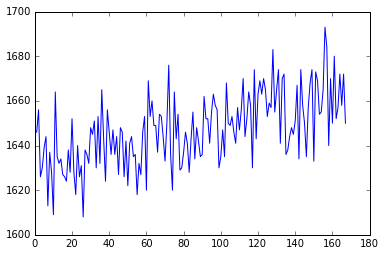

In [17]:
# load this image, get the 32,32,15 voxel time series without the 5 first points
to_rm = 5
img = nib.load(my_path_to_file)
print(img.shape)
(x,y,z) = (32,32,15)
plt.plot(img.get_data()[x,y,z,to_rm:])


In [18]:
# normalize the time series to have mean 100. call result 'bold'

bold = np.asarray(img.get_data()[x,y,z,to_rm:])
bold_std = bold.std()
bold_mean = bold.mean()
print(bold_std, bold_mean)


15.9044132678 1647.08928571


In [19]:
# Normalized to have mean 100
bold = bold * 100. / bold_mean
bold_std = bold.std()
bold_mean = bold.mean()
sig_mag = 2*bold_std
print(bold_std, bold_mean, sig_mag)

0.965607232455 100.0 1.93121446491


(42, 3)


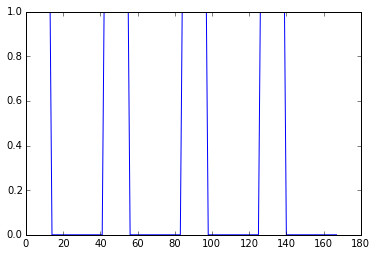

In [20]:
# divide the total duration time in 12, into 12 intervals of "cond_duration" TR
# we will fill the time with 3 conditions, (eg A,B,C)
# A, B will be our experimental conditions, C is for control condition (baseline)

cond_duration = bold.shape[0] // 12 # integer division

# make a signal for two conditions: A, B. Each block of A or B lasts for cond_duration, 
# and these blocks occur regularely, eg if the time is divided in 12 intervals,
# 'A' blocks will occur at intervals 0, 3, 6, 9, 'B' at intervals 1, 4, 7, 10, and the 
# remaining intervals will be baseline 

ones = np.ones((cond_duration,1))
a = np.kron(np.eye(3), ones) 

print(a.shape)
signal_A = np.kron(np.ones(4), a[:,0]).flatten()
signal_B = np.kron(np.ones(4), a[:,1]).flatten()
baseline = np.ones(shape=(bold.shape[0]))
plt.plot(signal_A)

(168, 3)


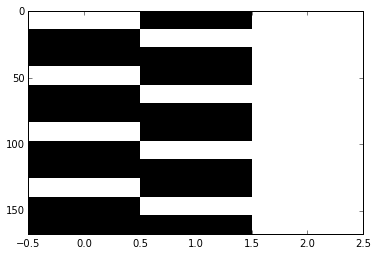

In [21]:

X = np.vstack((signal_A, signal_B, baseline)).T
plt.imshow(X,aspect='auto',interpolation='nearest')
print(X.shape)

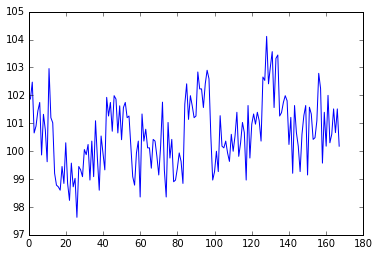

In [25]:
# add some signal with a signal to noise ratio of 2, 
# sig_mag = 2*bold_std

c = [sig_mag, 0, 0]
Y = X.dot(c) + bold
plt.plot(Y)

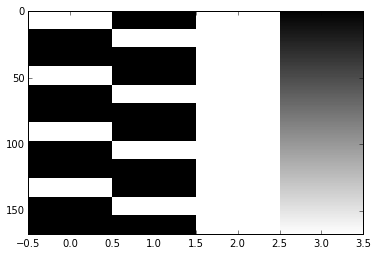

In [26]:
# Add a trend to X, call this new matrix X2
trend = np.arange(X.shape[0])[:,np.newaxis]/X.shape[0]
#trend -= trend.mean()
X2 = np.hstack((X, trend))
plt.imshow(X2,aspect='auto',interpolation='nearest')


### Now, recall the GLM and how to test a contrast 

Looking again at our time series, we should add a trend...

In [34]:
# estimate the parameters of the model using 

pinvX = npl.inv(X.T.dot(X)).dot(X.T) # this is to match the formula we have seen, 
pinvX2 = npl.inv(X2.T.dot(X2)).dot(X2.T) # in practice do not use this, use npl.pinv(X2)

beta = pinvX.dot(Y)
beta2 = pinvX2.dot(Y)
print(beta, beta2)

[   1.476   -0.4    100.285] [  1.791  -0.243  99.189   1.89 ]


We note our estimates 'beta' $\hat{\beta}_1$, $\hat{\beta}_2$, $\hat{\beta}_3$, etc

### Now, we need to _test_ if our signal of interest $\hat{\beta}_1$ is significant

We will need 2 things: signal, and standard error of the signal.

#### First, what is our observed signal of interest ?

In [47]:
# express our signal of interest as c.dot(beta2)
c = np.asarray([1,0,0,0]).reshape(4,1)
signal = c.T.dot(beta2[:,np.newaxis])[0,0]
print(signal)

1.79078381458


#### Second, what is our observed standard error ?

Recall the linear model for one observation i :

$$ Y_i = X \beta + \epsilon_i $$

and in matrix form:

$$ Y = X \beta + \epsilon $$

with $ \epsilon_i $ independant gaussian variable with variance $\sigma^2$, such that the vector $\epsilon$ has variance $\sigma^2 I$  and $I$ the identity matrix.

Our OLS estimates are:

$$ \hat\beta = (X^tX)^{-1}X^t Y $$

Our fitted data : 

$$ \hat{Y} =  X\hat\beta = X(X^tX)^{-1}X^t Y = M_X Y$$

And our residuals:

$$ r = \hat{\epsilon} = Y - \hat{Y} = Y - M_X Y  = (I - M_X) Y = R_X Y $$

$R_X$ or $R$  when there is no ambiguity, is the __residual forming__ matrix. 


Let's now  compute $ \mathrm{var}(c^T \hat\beta) $. We have

$$ \mathrm{var}(c^T \hat\beta) = \mathrm{var}(c^T (X^tX)^{-1}X^t Y) \qquad  (A)  $$ 

Let's call $ X^+ = (X^tX)^{-1}X^t $.

We have assumed that $\mathrm{var}(Y) = \sigma^2 I$
with $I$ the identity matrix.

$$ (A) \;\; = c^T X^+ \mathrm{var}(Y) X^{+T} c  = \sigma^2 c^T X^+ X^{+T} c = \sigma^2 c^T (X^T X)^- c $$ 



#### How do we know $\sigma$ ? We don't, we have to estimate it. 

First, we will need the residual sum of square:

Our residuals, the estimated noise, are $ r = \hat{\epsilon} = Y - \hat{Y} $, with $ \hat{Y} = X \hat{\beta}$

The residual sum of squre is :

$$ \textrm{RSS} = \sum_{i=1}^{n} (Y_i - \widehat{Y_i})^2 $$

But the mean sum of square is not the simple division by the number of time points, we have to correct for the number of estimation we have done when computing $\widehat{Y}$, so that will be 

$$\hat\sigma^2 = \textrm{RSS} / (n - p)$$

Where p here is 4, and n = 196.

This estimation is also called the **Mean Residual Sum of Square** (MRSS), and $\hat\sigma = \textrm{MRSS} = \textrm{RSS} / \it{df} $  where $\it{df}$ is the degrees of freedom $(n-p) = 12 - 3$, the number of observations (here, 12) minus the rank of the design matrix (here 3). In other word, this is the estimation of our noise.

Coming back to our t-statistics, we can now calculate the **Standard Error** (SE) of $c^T \hat\beta$ with $\textrm{SE} = \sqrt{\hat{\sigma}^2 c^T (X^t X)^+ c} $

The t test is then : $t = {c^T \hat\beta}/{\textrm{SE}} $


In [50]:
# Compute the estimate of sigma: compute the residuals, take the sum of square, divide by n-p
# n is the number of observations, p is the number of (free) parameters that we estimate

n,p = X2.shape # ok because X has no linear dependencies for its columns !

r = Y - X2.dot(beta2)

RSS = (r**2).sum()

sigma2_hat = RSS/(n - p)

In [51]:
RSS, sigma2_hat

(102.52301794921252, 0.62514035334885676)

In [55]:
# what can you say of this compared to bold_std ? Compute the standard error of the signal

V_1 = npl.inv(X2.T.dot(X2))

SE = np.sqrt( sigma2_hat * c.T.dot(V_1).dot(c))[0,0]
print(V_1, "\n", SE)


[[ 0.038  0.019 -0.025  0.013]
 [ 0.019  0.036 -0.022  0.006]
 [-0.025 -0.022  0.043 -0.044]
 [ 0.013  0.006 -0.044  0.076]] 
 0.153752432606


In [67]:
# compute the t statistics, that follows a student distribution with n-p df

t_observed = signal/SE
print(t_observed)

11.647190124


In [68]:
signal, sigma2_hat, SE

(1.7907838145792139, 0.62514035334885676, 0.15375243260563373)

#### How far from the t distribution centered on 0 ?

In [60]:
import scipy.stats as sst

In [61]:
df = n-p
t_variable = sst.t(df)

In [69]:
t_variable.sf(t_observed)

1.5696297660275469e-23

###  F statistics and model selection

#### Review the F test

The F-test is best understood in terms of model selection.
The question we are asking is : should all the regressor be in the model ? 

To answer this, we construct a reduced model X0 from X. From this model we look at the RSS of model X (full model) and model X0 (reduced). The residuals are always going to be larger for the reduced model (how do we prove this ? Let's see in class). 

$$
\begin{eqnarray} 
F_{\nu_1, \nu_2} & = & \frac{(\hat\epsilon_0^t \hat\epsilon_0 - \hat\epsilon^T\hat\epsilon)/ \nu_{1} }{\hat\epsilon^T\hat\epsilon/\nu_{2}} \\ 
 & = & \frac{(Y^TR_{X_0}Y - Y^TR_{X}Y)/ \nu_{1} }{Y^TR_{X}Y/\nu_{2}} \\ 
 & = & \frac{(Y^T(I-P_{X_0})Y - Y^T(I-P_{X})Y)/ \nu_{1} }{Y^T(I- P_{X})Y/\nu_{2}} \\ 
& = & \frac{(\textrm{SSR}(X_0) - \textrm{SSR}(X))/\nu_1}{\textrm{SSR}(X)/\nu_2}
\end{eqnarray}
$$